# RNA-Seq Analysis: From Bulk to Single-Cell
Welcome to the third Bioinformatics tutorial. In this session, we will delve deep into the world of transcriptomics, exploring both traditional bulk RNA-seq and the cutting-edge technique of single-cell RNA-seq. As we journey through these methodologies, we will discuss the foundational principles, the key differences, and the unique challenges and opportunities each presents. Whether you are new to the realm of RNA sequencing or looking to expand your knowledge on these specific techniques, this tutorial aims to provide a comprehensive understanding, equipping you with the skills and insights to analyze and interpret RNA-seq data effectively.

# Task 1. Differential Gene Expression Analysis and Visualization with Synthetic Data

In [51]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

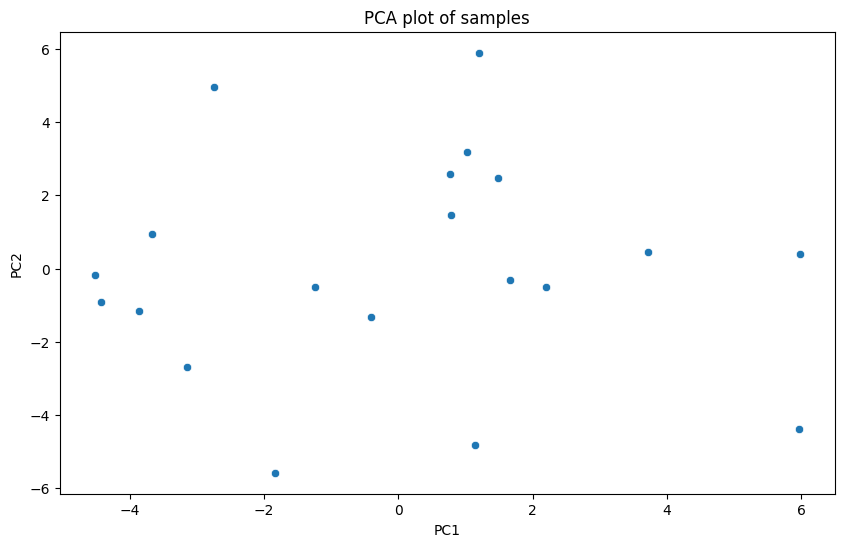

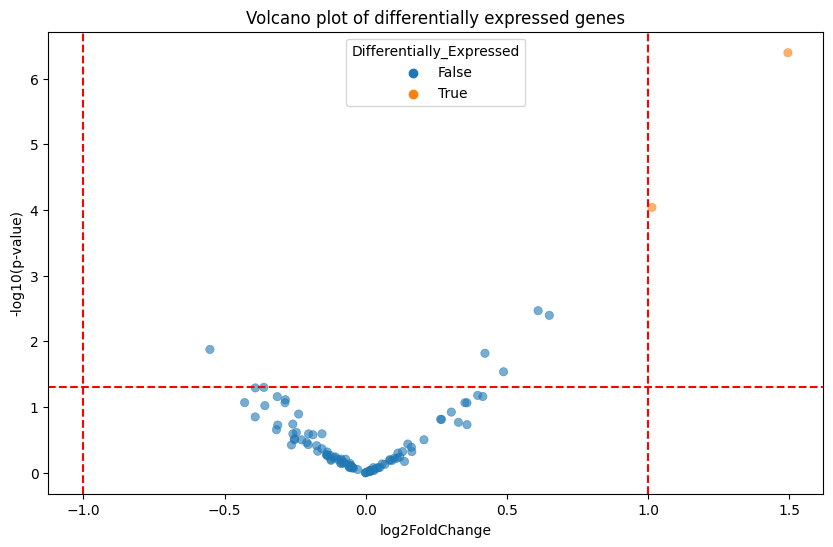

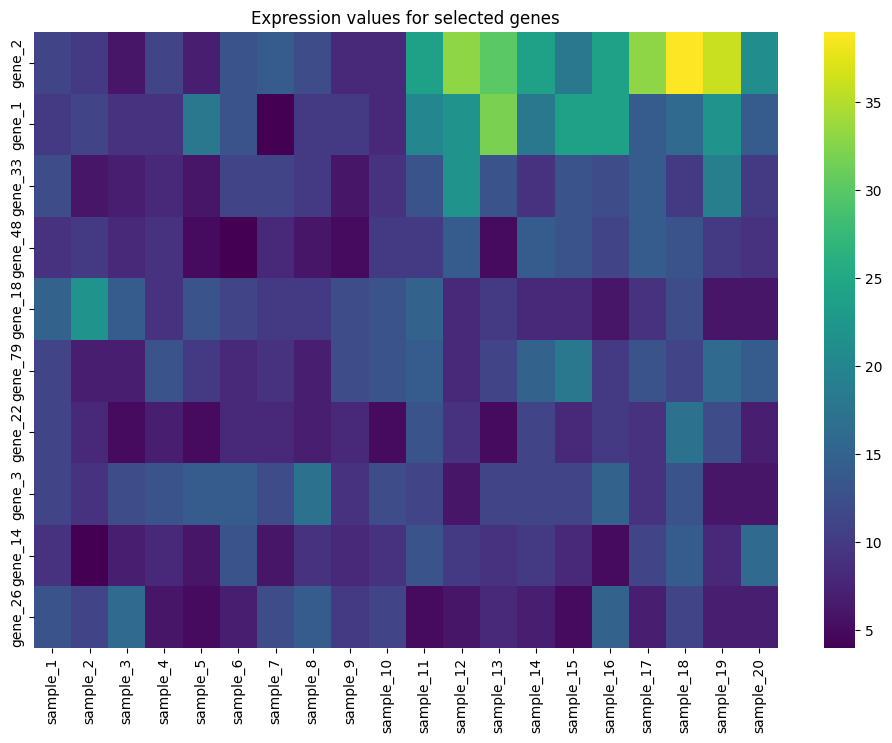

In [52]:
# Generating synthetic data
np.random.seed(0)
samples = ['sample_' + str(i) for i in range(1, 21)]
genes = ['gene_' + str(i) for i in range(1, 101)]
ge_matrix_subset = pd.DataFrame(np.random.poisson(10, (100, 20)), index=genes, columns=samples)

# Simulating differential expression for Th0 (samples 1-10) and Th2 (samples 11-20)
ge_matrix_subset.loc['gene_1', 'sample_11':'sample_20'] *= 2
ge_matrix_subset.loc['gene_2', 'sample_11':'sample_20'] *= 3

# Differential expression analysis
log2FoldChanges = []
p_values = []

# Split data into two conditions: Th0 and Th2
th0_data = ge_matrix_subset.iloc[:, 0:10]
th2_data = ge_matrix_subset.iloc[:, 10:20]

for gene in ge_matrix_subset.index:
    t_stat, p_val = ttest_ind(th0_data.loc[gene], th2_data.loc[gene])
    log2FoldChange = np.log2(th2_data.loc[gene].mean() / th0_data.loc[gene].mean())
    log2FoldChanges.append(log2FoldChange)
    p_values.append(p_val)

p_adjusted = multipletests(p_values, method='fdr_bh')[1]  # Benjamini/Hochberg correction

res_df = pd.DataFrame({
    'Gene': ge_matrix_subset.index,
    'log2FoldChange': log2FoldChanges,
    'p-value': p_values,
    'adj_p-value': p_adjusted
})

res_df['-log10(p-value)'] = -np.log10(res_df['p-value'])
res_df['Differentially_Expressed'] = (res_df['log2FoldChange'].abs() > 1) & (res_df['adj_p-value'] < 0.05)

# Visualization - PCA
data_for_pca = scale(ge_matrix_subset.T)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_for_pca)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('PCA plot of samples')
plt.show()

# Visualization - Volcano Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log2FoldChange', y='-log10(p-value)', data=res_df,
                hue='Differentially_Expressed', edgecolor=None, alpha=0.6)
plt.title('Volcano plot of differentially expressed genes')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--')
plt.axvline(x=-1, color='red', linestyle='--')
plt.axvline(x=1, color='red', linestyle='--')
plt.show()

# Visualization - Heatmap
top_genes = res_df.nsmallest(10, 'adj_p-value')['Gene']
heatmap_data = ge_matrix_subset.loc[top_genes]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', yticklabels=True, xticklabels=True)
plt.title('Expression values for selected genes')
plt.show()

# Task 2. Analyzing Single-Cell RNA Sequencing (scRNA-seq) Data
Analyzing single-cell RNA sequencing (scRNA-seq) data in Python can be more complex than bulk RNA-seq data due to the additional dimensions (i.e., many individual cells) and the sparsity of the data.

In [62]:
#!pip install scanpy anndata
import scanpy as sc
import scipy

# Assuming data is in a 10X Genomics format
# Go to https://github.com/dieterich-lab/single-cell-nanopore/tree/master/data and download those 3 files:
# 1- matrix.mtx.gz
# 2- features.tsv.gz
# 3- barcodes.tsv.gz
adata = sc.read_10x_mtx(
    '/content/',  # directory with `.mtx` file
    var_names='gene_symbols',   # use gene symbols for variable names (genes)
    cache=True                  # cache preprocessing results
)

/usr/local/lib/python3.10/dist-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [64]:
# 1. Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# 2. Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# 3. Logarithmize the data
sc.pp.log1p(adata)

# 4. Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]

# 5. Calculate the total counts per cell and the percentage of mitochondrial genes expressed
# First, make sure mitochondrial genes are identified correctly.
# If your dataset uses a different prefix for mitochondrial genes, adjust the following line.
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]

# Ensure we've identified mitochondrial genes. If not, inspect and adjust the prefix.
if not mito_genes:
    raise ValueError("No mitochondrial genes identified! Please check the prefix.")

adata.obs['n_counts'] = adata.X.sum(axis=1)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

# 6. Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

# 7. Scale each gene to unit variance, clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

<ipython-input-64-9dbe41287ec3>:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = adata.X.sum(axis=1)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


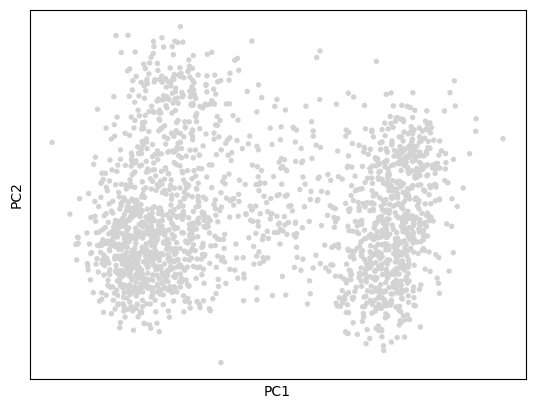

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


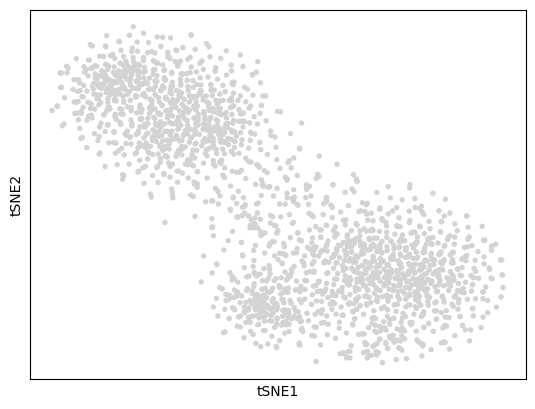

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


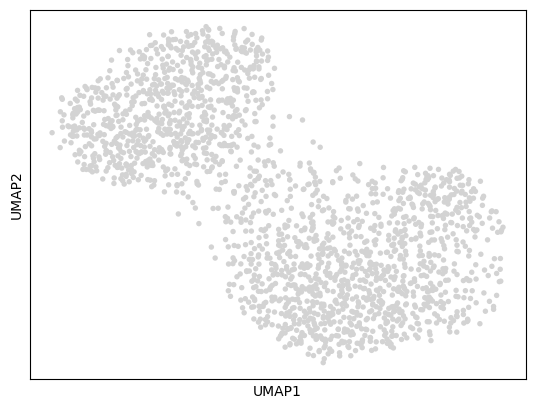

In [65]:
# PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

# t-SNE
sc.tl.tsne(adata)
sc.pl.tsne(adata)

# UMAP (another popular visualization for scRNA-seq)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.pl.umap(adata)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


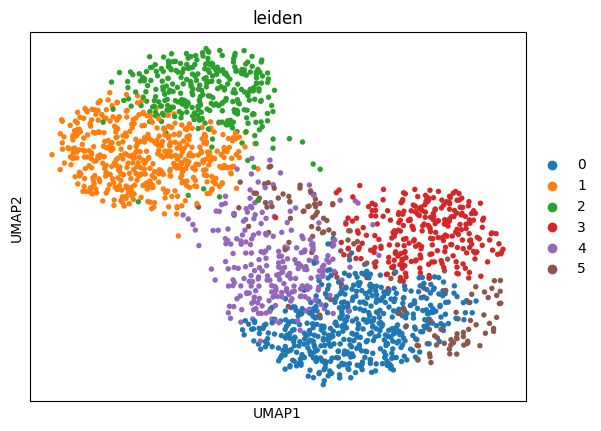

In [68]:
!pip install leidenalg
sc.tl.leiden(adata)  # Leiden algorithm
sc.pl.umap(adata, color=['leiden'])